# LAB 2 - Matheus Gomes Maia
## ATIVIDADE
* 1 Reproduza a tabela 4.1 do livro texto calculando as estatísticas para sua coleção (5 pts).
* 2 Reproduza a tabela 4.2 do livro considerando as top-50 palavras mais frequentes de sua coleção (5 pts). 
* 3 Plote curvas de rank-frequência (usando escala logarítmica) para palavras e bigramas na coleção que você coletou na atividade anterior. Quais os melhores valores do parâmetro c para cada curva (5 pts)?
* 4 Reproduza a tabela 4.5 do livro texto considerando a sua coleção (5 pts).

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nltk
import string
import re
from scipy.optimize import minimize_scalar
import seaborn as sns
pd.set_option("display.max_rows",40)

%matplotlib inline
nltk.download('punkt')

[nltk_data] Downloading package punkt to /home/maia/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

## Load Data

In [2]:
#Load all news
data = pd.read_csv('results.csv')
data= data.drop_duplicates(subset='url', keep='last')


#Pre process news
# Tokenize, Join and Filter
# Words into a new data Frame
txt = [str(news) for news in data["text"].tolist()]
words = [nltk.word_tokenize(sentence) for sentence in txt]
words = [item for sublist in words for item in sublist] 
words=[word.lower() for word in words if (word.isalpha() and (len(word) > 3))] 

# New Data frame with Word, Frequency and Ranking columns 
words_df = pd.DataFrame(words, columns=['word']) #All words
word_counts = words_df.word.value_counts().reset_index() #Join by word. Adds Frequency
word_counts.columns = ['Word', 'Freq'] #Naming columns 
word_counts['word_rank'] = word_counts.Freq.rank(ascending=False) #Adds ranking

## 1 Reproduza a tabela 4.1 do livro texto calculando as estatísticas para sua coleção (5 pts).

In [3]:
#Calculate
total = len(txt) 
total_words = len(words)
vocabulary_size = len(word_counts)
words_thousand = len(word_counts[word_counts['Freq'] > 1000])
words_once = len(word_counts[word_counts['Freq'] == 1])

#Print
labels = ["Total Documents", "Total word occurrences", "Vocabary Size", "Words ocurring > 1000 times", "Words ocurring once"]
values = [total, total_words, vocabulary_size, words_thousand, words_once]
for i in range(len(values)):
    print(labels[i], (30-len(labels[i]))*"-", values[i])

Total Documents --------------- 129
Total word occurrences -------- 32889
Vocabary Size ----------------- 8651
Words ocurring > 1000 times --- 0
Words ocurring once ----------- 4504


## 2 Reproduza a tabela 4.2 do livro considerando as top-50 palavras mais frequentes de sua coleção (5 pts). 

In [4]:
# Prob = Frequency/Total of words
word_counts['Prob. Per cent'] = (word_counts.Freq/total_words)*100
word_counts['Prob.'] = word_counts.Freq/total_words

print(word_counts)

              Word  Freq  word_rank  Prob. Per cent     Prob.
0             para   748        1.0        2.274317  0.022743
1             mais   276        2.0        0.839186  0.008392
2             como   246        3.0        0.747970  0.007480
3            disse   193        4.0        0.586822  0.005868
4           também   176        5.0        0.535133  0.005351
5          governo   150        6.0        0.456080  0.004561
6             pela   148        7.0        0.449998  0.004500
7            sobre   144        8.0        0.437836  0.004378
8             está   140        9.0        0.425674  0.004257
9       presidente   139       10.0        0.422634  0.004226
10            pelo   129       11.0        0.392228  0.003922
11           entre   113       12.0        0.343580  0.003436
12           ainda    99       13.0        0.301012  0.003010
13            isso    98       14.0        0.297972  0.002980
14         pessoas    94       15.0        0.285810  0.002858
15      

## 3 Plote curvas de rank-frequência (usando escala logarítmica) para palavras e bigramas na coleção que você coletou na atividade anterior. Quais os melhores valores do parâmetro c para cada curva (5 pts)?

In [5]:
#Brigrams
# Nltk to produce bigrams and join both words
bigrm = [' '.join(b) for b in list(nltk.bigrams(words))]
bigrm_df = pd.DataFrame(bigrm, columns=['bigrm'])

# New Data Frame with bigram, frequency and ranking
bigrm_counts = bigrm_df.bigrm.value_counts().reset_index()
bigrm_counts.columns = ['bigrm', 'Freq']
bigrm_counts['bigrm_rank'] = bigrm_counts.Freq.rank(ascending=False)
# print(bigrm_counts)

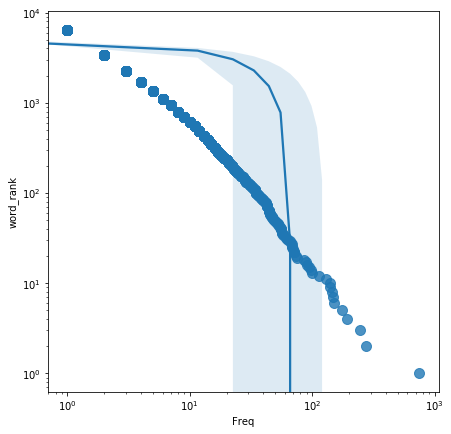

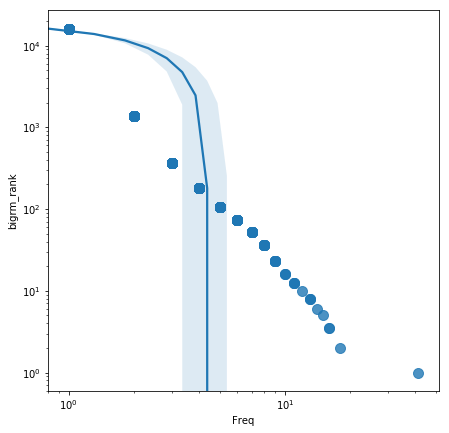

In [9]:
#Plot Rank - Frequency
f, ax = plt.subplots(figsize=(7, 7))
ax.set(xscale="log", yscale="log")
sns.regplot("Freq", "word_rank", word_counts, ax=ax, scatter_kws={"s": 100})

f, ax = plt.subplots(figsize=(7, 7))
ax.set(xscale="log", yscale="log")
sns.regplot("Freq", "bigrm_rank", bigrm_counts, ax=ax, scatter_kws={"s": 100})

In [6]:
#Fuction used to calculate Zipf's law coefficient (Not the c, but as usefull)
def loglik(b):  
    # Power law function
    Probabilities = freq_c**(-b)

    # Normalized
    Probabilities = Probabilities/Probabilities.sum()

    # Log Likelihoood
    Lvector = np.log(Probabilities)

    # Multiply the vector by frequencies
    Lvector = np.log(Probabilities) * freq_word_counts

    # LL is the sum
    L = Lvector.sum()

    # We want to maximize LogLikelihood or minimize (-1)*LogLikelihood
    return(-L)

Melhor valor do parâmetro c para palavras soltas é:  1.8183118015940865


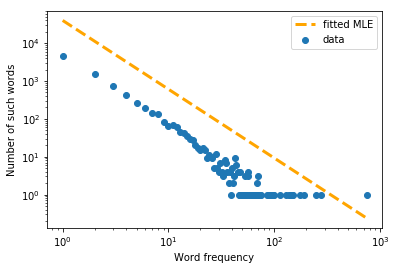

In [13]:
# Group all words with same freq
word_counts_new = word_counts.filter(['Freq','Word'], axis=1)
word_counts_new_group = word_counts_new.groupby(['Freq'], as_index=False).count()

# Lists of frequencys and number of words for each frequency
freq_c = np.asarray(word_counts_new_group['Freq'])
freq_word_counts = np.asarray(word_counts_new_group['Word'])

# Find best c
s_best = minimize_scalar(loglik, [0.01, 4.0] )


f,ax = plt.subplots()
ax.scatter(freq_c, freq_word_counts, label = "data")
ax.set_xlabel('Word frequency')
ax.set_ylabel('Number of such words')
ax.set_xscale("log")
ax.set_yscale("log")


ax.plot(freq_c[0:2*10**2], 4*10**4*freq_c[0:2*10**2]**-s_best.x, '--', color="orange", lw=3, label = "fitted MLE")
ax.legend()
print("Melhor valor do parâmetro fa lei de Zipf para palavras soltas é: ", s_best.x)

Melhor valor do parâmetro c para bigramas é:  3.9817601847299113


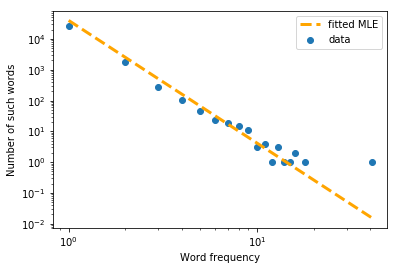

In [8]:
# Group all bigrams with same freq
bigrm_counts_new = bigrm_counts.filter(['Freq','bigrm'], axis=1)
bigrm_counts_new_group = bigrm_counts_new.groupby(['Freq'], as_index=False).count()

# Lists of frequencys and number of bigrams for each frequency
freq_c = np.asarray(bigrm_counts_new_group['Freq'])
freq_word_counts = np.asarray(bigrm_counts_new_group['bigrm'])

# Find best  zipf constant
s_best = minimize_scalar(loglik, [0.01, 4.0] )

#Plot
f,ax = plt.subplots()
ax.scatter(freq_c, freq_word_counts, label = "data")
ax.set_xlabel('Frequency')
ax.set_ylabel('Number of such words')
ax.set_xscale("log")
ax.set_yscale("log")
ax.plot(freq_c[0:2*10**2], 4*10**4*freq_c[0:2*10**2]**-s_best.x, '--', color="orange", lw=3, label = "fitted MLE")
ax.legend()
print("Melhor valor do parâmetro da lei de Zipf para bigramas é: ", s_best.x)

## 4 Reproduza a tabela 4.5 do livro texto considerando a sua coleção (5 pts).

In [10]:
# Group by Freq
word_counts_new = word_counts.filter(['Freq','Word'], axis=1)
word_counts_groupby = word_counts_new.groupby(['Freq'], as_index=False).count()

#Add new columns 
word_counts_groupby['Predicted Prop'] = 1/(word_counts_groupby.Freq*(word_counts_groupby.Freq+1))
word_counts_groupby['Actual Prop'] = word_counts_groupby.Word/vocabulary_size
word_counts_groupby['Actual Number of Words'] = word_counts_groupby.Word

#Print
pd.set_option('display.float_format', lambda x: '%.3f' % x)
print(word_counts_groupby)

    Freq  Word  Predicted Prop  Actual Prop  Actual Number of Words
0      1  4504           0.500        0.521                    4504
1      2  1524           0.167        0.176                    1524
2      3   722           0.083        0.083                     722
3      4   436           0.050        0.050                     436
4      5   259           0.033        0.030                     259
5      6   196           0.024        0.023                     196
6      7   144           0.018        0.017                     144
7      8   137           0.014        0.016                     137
8      9    84           0.011        0.010                      84
9     10    64           0.009        0.007                      64
10    11    68           0.008        0.008                      68
11    12    60           0.006        0.007                      60
12    13    44           0.005        0.005                      44
13    14    43           0.005        0.005     